In [10]:
import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from xml.dom import minidom
import re
import json

from random import shuffle

In [11]:
with open('workspace/road_damage/inference-config.json', 'r') as f:
    CONFIGURATION = json.load(f)


In [ ]:
'''
Doesnt redownload the file when already downloaded. Which is fantastic.
'''
def validate_and_load_existing_model():
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = CONFIGURATION['CHOSEN_MODEL'] + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=CONFIGURATION['CHOSEN_MODEL'], 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"
  print(model_dir)

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

MODEL = validate_and_load_existing_model()

In [12]:
def load_from_path():
    print(CONFIGURATION['MODEL_PATH'])
    model = tf.saved_model.load(CONFIGURATION['MODEL_PATH'])
    model = model.signatures['serving_default']
    return model

MODEL = load_from_path()

D:/university/datasets/Potholes/training/output/saved_model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [20]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  category_index = label_map_util.create_category_index_from_labelmap(CONFIGURATION['PATH_TO_LABELS'], use_display_name=True)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))


Try to find accurate enough inference for  D:/university/datasets/Potholes/images\529.jpg
Try to find accurate enough inference for  D:/university/datasets/Potholes/images\44.jpg
Try to find accurate enough inference for  D:/university/datasets/Potholes/images\447.jpg
Try to find accurate enough inference for  D:/university/datasets/Potholes/images\88.jpg
Try to find accurate enough inference for  D:/university/datasets/Potholes/images\234.jpg
Try to find accurate enough inference for  D:/university/datasets/Potholes/images\90.jpg


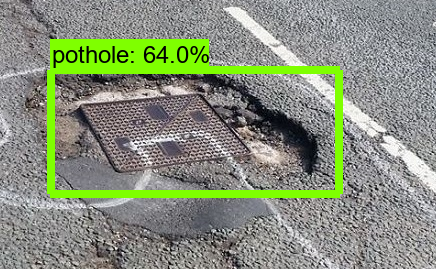

In [22]:
def find_best_inference():
    model = MODEL
    images_list = os.listdir(CONFIGURATION['IMAGES_PATH'])
    shuffle(images_list)
    for img_name in images_list:
        img_path = os.path.join(CONFIGURATION['IMAGES_PATH'], img_name)
        print('Try to find accurate enough inference for ', img_path)
        image_np = np.array(Image.open(img_path))
        try:
            output_dict = run_inference_for_single_image(model, image_np)
            if output_dict['detection_scores'][0] > 0.5:
                show_inference(MODEL, img_path)
                break
        except:
            print('Error occurred while processing',img_path)
        
find_best_inference()   

In [ ]:
images_list = os.listdir(CONFIGURATION['IMAGES_PATH'])
shuffle(images_list)

image_absolute_name = os.path.join(CONFIGURATION['IMAGES_PATH'], images_list[0])
print(images_list[0], image_absolute_name)

show_inference(MODEL, image_absolute_name)



In [ ]:
images_list = os.listdir(CONFIGURATION['IMAGES_PATH'])
shuffle(images_list)

image_absolute_name = os.path.join(CONFIGURATION['IMAGES_PATH'], images_list[0])
print(images_list[0], image_absolute_name)

show_inference(MODEL, image_absolute_name)

